## Udemy Course Price Tracker
Udemy offers a wide range of courses for learning new skills, with standard prices typically between $100 and $250. However, Udemy frequently runs flash sales, offering discounts from 50% to 80%, which can significantly reduce course costs.

The challenge is that Udemy does not notify users about these sales through promotional emails, making it easy to miss these savings opportunities. This project aims to create a price tracker that monitors the cost of a specified course. When the course is available at a discounted price, the user receives an email alert, allowing them to purchase at the best possible price.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
from selenium import webdriver

import http.client
import json
import os
import csv
import datetime

import pandas as pd
import matplotlib.pyplot as plt

# Email sender
import os
from email.message import EmailMessage
import ssl
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
from email.mime.image import MIMEImage

In [2]:
# The udemy course url
url = 'https://www.udemy.com/course/complete-dbt-data-build-tool-bootcamp-zero-to-hero-learn-dbt/'

We will first attempt to use BeautifulSoup to get the data.

In [3]:
headers = {
    "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
else: 
    print(f'Error Code: {response.status_code}')

Error Code: 403


Here we get a 403 error, meaning the server understood the request but refused to fulfill it. So we have to find another alternative method to get the data.

### Using Selenium & BeautifulSoup
Here we will get course ID which we'll use later on.

In [4]:
# get coursid from url
driver = webdriver.Chrome()
driver.get(url) 

page_source = BeautifulSoup(driver.page_source, 'html.parser') 
htmlText = page_source.select('body[id="udemy"]')
courseid = htmlText[0].get('data-clp-course-id')

# close broswer
driver.close()
print(f'Course ID: {courseid}')

Course ID: 4405768


### Using the API

In [5]:
conn = http.client.HTTPSConnection('www.udemy.com')

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US',
    'Referer': url,
    'X-Requested-With': 'XMLHttpRequest'
}

conn.request(
    'GET',
    f'/api-2.0/pricing/?course_ids={courseid}&fields[pricing_result]=price,discount_price,list_price,price_detail,price_serve_tracking_id',
    headers=headers
)
response = conn.getresponse()

if response.status == 200:

    # then we read the response and store as a df 
    data = response.read()
    df =json.loads(data)

else: 
    print(f'Error Code: {response.status}')

Variables

In [6]:
coursePricing = df['courses'][str(courseid)]

originalPrice = coursePricing['list_price']['amount'] # Original price
discountPrice = coursePricing['price']['amount'] # Discount Price

# get course name
courseURL = headers['Referer']
courseName = courseURL.split('/')[4].replace('-',' ').title()

# today's price
today = datetime.date.today()

Save in csv file to track the prices 

In [7]:
header = ['Course','Price','Discount Price','Date']
data = [courseName, originalPrice, discountPrice, today]

# insert into our csv
with open('CoursePriceTracker.csv', 'a+', newline='', encoding='UTF8') as f:
    writer = csv.writer(f)
    #writer.writerow(header)
    writer.writerow(data)

# preview the csv
csv_data = pd.read_csv(r'./CoursePriceTracker.csv').drop_duplicates().reset_index(drop=True)
desired_course = csv_data[csv_data['Course'] == courseName].copy() # get for a specific course

desired_course['Date'] = pd.to_datetime(desired_course['Date'])  # Convert 'Date' column to datetime
time_period = (desired_course['Date'].max() - desired_course['Date'].min()).days
desired_course.head()

,Course,Price,Discount Price,Date
0,Complete Dbt Data Build Tool Bootcamp Zero To ...,109.99,17.99,2024-10-28
1,Complete Dbt Data Build Tool Bootcamp Zero To ...,109.99,109.99,2024-10-29


Plot the price trends in the last days.

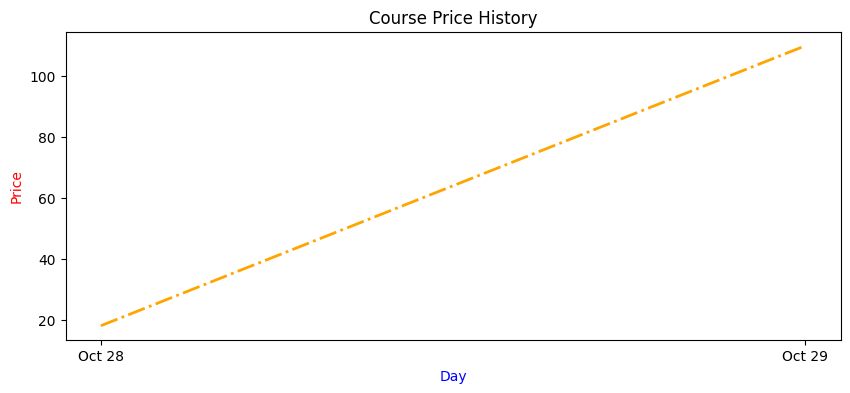

In [8]:
# Plot the image and attach to the email
fig, axes = plt.subplots(figsize = (10,4))

# convert date to readable day
desired_course['Day'] = desired_course['Date'].dt.strftime('%b %d')

axes.plot(desired_course['Day'], desired_course['Discount Price'], color = 'orange',
          lw = 2, linestyle = '-.')

axes.set_title('Course Price History')
axes.set_xlabel('Day', color="blue")
axes.set_ylabel('Price', color="red")
plt.show()

# Export the image
fig.savefig('CourseTrackerImage.png', dpi=100)

Send an email when we have a discount or drop in price.

In [9]:
setAmount = 20 # custom set price

# if the discount price is below a certain amount OR if the dictionary is not empty then send email
if coursePricing.get('discount_price') is not None or discountPrice < setAmount:
    
    # send email
    email_sender = '##' # insert sender email
    email_password = os.environ.get("GMAIL_PASSWORD")
    email_receiver = '##' # insert receiver email

    subjectText = courseName.split( )[0] + ' ' + courseName.split( )[1]+ ' ... ' \
            + courseName.split( )[-2] + ' ' + courseName.split( )[-1]
    
    subject = f'UDEMY PRICE DROP!! {subjectText} is now ${discountPrice}!'

    body = f"""
    <html>
    <body>
        <p>Good day Razak,<br>
        <br>
        The <strong>{courseName}</strong> course is now on sale for <strong>${discountPrice}</strong> on Udemy. <br>
        Here's the link to the course - <a href="{courseURL}">{courseURL}</a><br>
        Below is the price trend for the last <strong>{time_period}</strong> days.</p>
        <img src="cid:embedded_image">
    </body>
    </html>
    """

    em = EmailMessage()
    em['From'] = email_sender
    em['To'] = email_receiver
    em['Subject'] = subject
    em.set_content(body, subtype='html')
    em.add_alternative(body, subtype='html')

    # Open the image file in binary mode
    with open('./CourseTrackerImage.png', 'rb') as img_file:
        img_data = img_file.read()

    # Add image as inline content
    image = MIMEImage(img_data)
    image.add_header('Content-ID', '<embedded_image>')
    #em.attach(image)
    

    # add security
    context = ssl.create_default_context()

    # send email
    with smtplib.SMTP_SSL('smtp.gmail.com', port=465, context=context) as smtp:

        # log in and send email
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email_receiver, em.as_string())

    print(f'Email sent to {email_receiver}!')
    
else:
     print('Not on sale today :(')

Not on sale today :(
